<a href="https://colab.research.google.com/github/piaseckazaneta/CV/blob/master/theEnergyStarScore_project_part_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

We will use the standard data science and machine learning libraries in this project.

In [3]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
#from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

First let's read in the formatted data from the previous notebook.

In [4]:
# Read in data into dataframes
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6749, 74)
Testing Feature Size:   (2893, 74)
Training Labels Size:   (6749, 1)
Testing Labels Size:    (2893, 1)


As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features.

In [5]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Indirect GHG Emissions (Metric Tons CO2e),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Site EUI (kBtu/ft²),log_Weather Normalized Site EUI (kBtu/ft²),log_Weather Normalized Site Electricity Intensity (kWh/ft²),log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Ambulatory Surgical Center,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Data Center,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Other - Technology/Science,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,4212,4932827,111567.0,1913,1,100,62.5,12.1,2217126.8,23407.5,402.3,18.37,40.769624,-73.968230,8.0,122.0,4.135167,4.155753,2.493205,4.768988,2.910719,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,6167,4406956,54030.0,1930,1,100,76.4,NaN,4716513.9,NaN,11.0,81.97,40.847999,-73.940296,12.0,265.0,4.335983,NaN,NaN,5.523459,4.406353,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,10770,4370684,149450.0,1934,1,100,53.2,2.8,5988399.9,63472.7,136.9,NaN,40.645638,-73.981046,12.0,498.0,3.974058,4.032469,1.029619,5.869014,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,6960,4401878,148827.0,1982,1,100,69.9,4.8,8491331.1,92259.8,245.0,NaN,40.821001,-73.895580,2.0,159.0,4.247066,4.306764,1.568616,6.111467,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4928,2682511,377823.0,1976,1,100

The score column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one!

Here's the distribution of the Energy Star Score.

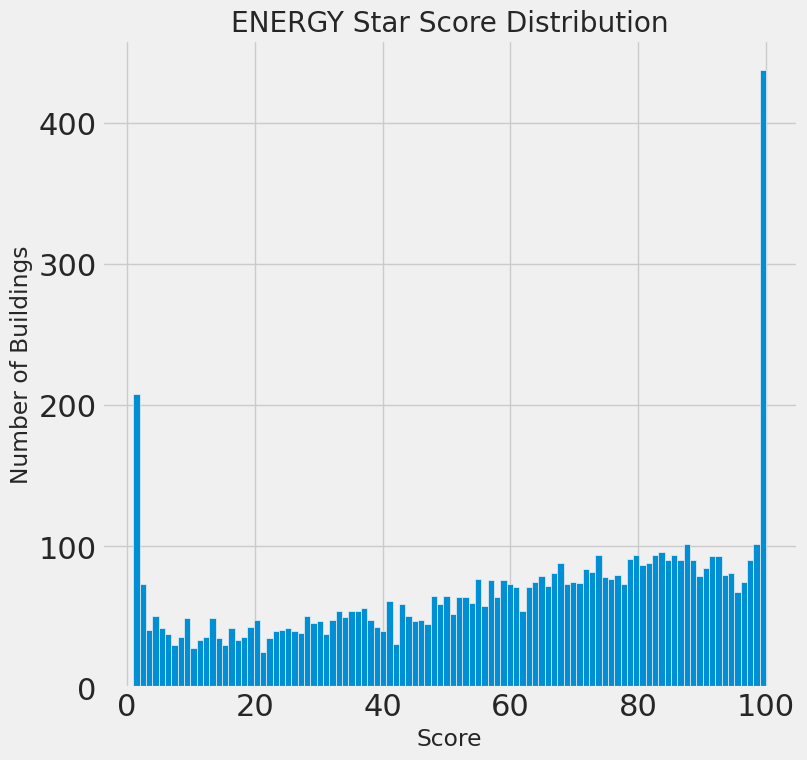

In [6]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('ENERGY Star Score Distribution');

### Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

We are comparing models using the mean absolute error. A baseline model that guessed the median value of the score was off by an average of 25 points.

## Imputing Missing Values

Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values, a process known as imputation). There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column. (Here is a more thorough discussion on imputing missing values)